# FRMasking Adverserial Training
Fixed Randomized Masking (FRMasking) is a novel adverserial training technique i'm proposing as an alternative to conventional adverserial training techniques which are time consuming and resource intensive. 

This notebook sequentially exxecutes the steps required to adverserially train a VGG16 model on CIFAR10 data using PGD & FRMasking

 #### Load Libraries

In [2]:
# !pip install tqdm matplotlib opencv-python joblib torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from tqdm import tqdm
import joblib

D:\Users\bhuva\Documents\conda_envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model = torchvision.models.vgg16_bn(pretrained=True)# torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(input_lastLayer, 10)
model.to(device)

D:\Users\bhuva\Documents\conda_envs\pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
D:\Users\bhuva\Documents\conda_envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Train base VGG16 model on CIFAR10

In [27]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.RandomHorizontalFlip()])


In [28]:
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

subset = torch.utils.data.Subset(trainset, indices=np.arange(40000))

trainloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


In [16]:
import torch.optim as optim
lr = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9,weight_decay=5e-4)

In [309]:
def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    lr = lr * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [18]:
def train(model, loader, num_epoch = 10): # Train the model
    print("Start training...")
    model.train() # Set the model to training mode
    for i in range(num_epoch):
        
        adjust_learning_rate(optimizer, i, lr)
        
        running_loss = []
        correct=0
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad() # Clear gradients from the previous iteration
            pred = model(batch) # This will call Network.forward() that you implement
            loss = criterion(pred, label) # Calculate the loss
            running_loss.append(loss.item())
            loss.backward() # Backprop gradients to all tensors in the network
            optimizer.step() # Update trainable weights
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
        acc = correct/len(loader.dataset)
        print(f"Epoch {i}\t\tacc: {acc:.4f}")
        print("\t\tloss: {}".format(np.mean(running_loss))) # Print the average loss for this epoch
    print("Done!")

In [19]:
epoch = 20
train(model, trainloader, epoch)

Start training...


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:06<00:00, 19.79it/s]


Epoch 0		acc: 0.7181
		loss: 0.8470979434251785


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:12<00:00, 18.90it/s]


Epoch 1		acc: 0.8477
		loss: 0.4570293367832899


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:11<00:00, 19.05it/s]


Epoch 2		acc: 0.8950
		loss: 0.31530093896761535


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:08<00:00, 19.52it/s]


Epoch 3		acc: 0.9195
		loss: 0.23776789084430783


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:10<00:00, 19.12it/s]


Epoch 4		acc: 0.9373
		loss: 0.18618623447748833


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:09<00:00, 19.33it/s]


Epoch 5		acc: 0.9493
		loss: 0.1511885683774017


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:08<00:00, 19.45it/s]


Epoch 6		acc: 0.9578
		loss: 0.12790297562555641


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:07<00:00, 19.66it/s]


Epoch 7		acc: 0.9648
		loss: 0.10783725403504213


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:07<00:00, 19.58it/s]


Epoch 8		acc: 0.9660
		loss: 0.10044398831169238


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:08<00:00, 19.50it/s]


Epoch 9		acc: 0.9723
		loss: 0.08291184283207403


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:08<00:00, 19.52it/s]


Epoch 10		acc: 0.9748
		loss: 0.07679520386731602


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:03<00:00, 20.23it/s]


Epoch 11		acc: 0.9769
		loss: 0.06818679165060748


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:06<00:00, 19.79it/s]


Epoch 12		acc: 0.9786
		loss: 0.06379558560164879


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:06<00:00, 19.80it/s]


Epoch 13		acc: 0.9805
		loss: 0.05867402332052443


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:05<00:00, 19.87it/s]


Epoch 14		acc: 0.9818
		loss: 0.05566974907485565


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:06<00:00, 19.79it/s]


Epoch 15		acc: 0.9844
		loss: 0.04629561780585354


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:06<00:00, 19.80it/s]


Epoch 16		acc: 0.9858
		loss: 0.043983520259318176


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:03<00:00, 20.31it/s]


Epoch 17		acc: 0.9837
		loss: 0.049142913313777535


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:03<00:00, 20.22it/s]


Epoch 18		acc: 0.9855
		loss: 0.043105383789508775


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:09<00:00, 19.35it/s]

Epoch 19		acc: 0.9870
		loss: 0.03930117091103457
Done!


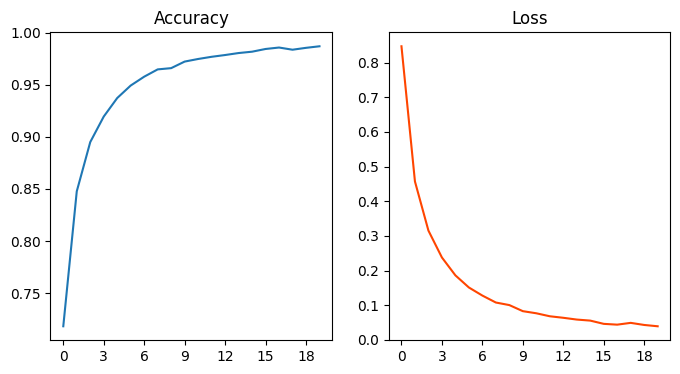

In [157]:
adv_train_metrics = joblib.load("adv_train_metrics.dump")

fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(adv_train_metrics["acc"])
ax[0].set_title("Accuracy")
ax[0].set_xticks(range(0,21,3))
ax[1].plot(adv_train_metrics["loss"], color='orangered')
ax[1].set_title("Loss")
ax[1].set_xticks(range(0,21,3))
plt.show()

In [28]:
np.unique(trainloader.dataset.dataset.targets[0:39999], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([3986, 3986, 4048, 3984, 4003, 3975, 4020, 4023, 3996, 3978],
       dtype=int64))

In [33]:
trainloader.dataset.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [29]:
torch.save(model, "vgg_cifar.h5")

Eval Base Model

In [4]:
batch_size = 32
test_transforms = transforms.Compose(
    [transforms.ToTensor()])

In [5]:
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [33]:
model = torch.load("vgg_cifar.h5")

In [17]:
def evaluate(model, loader): # Evaluate accuracy on validation / test set
    model.eval() # Set the model to evaluation mode
    correct = 0
    with torch.no_grad(): # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    print("Evaluation accuracy: {}".format(acc))
    return acc

In [46]:
og_acc = evaluate(model, testloader)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:09<00:00, 34.49it/s]

Evaluation accuracy: 0.8842


# FRMasking Steps Begin Here

### Attack train set on Trained VGG model

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class PerturbPGDIterBuff():
    def __init__(self, model, epsilon=0.007, alpha=0.001):
        self.epsilon = epsilon
        self.model = model
        self.steps = 2
        self.alpha = alpha
        self.device = device
    
    def attack(self, X, y, steps=None):
        if steps != None:
            self.steps = steps
        
        # Creating copy of input that gets iteratively perturbated
        # using torch.autograd.Variable through the process since without it gradients arent being stored
        X_updt = torch.autograd.Variable(X.data, requires_grad=True)
        all_step_X_updts = [None] * (self.steps-2)
        
        # print("Num Steps: ", self.steps)
        
        for i in range(0,self.steps):
            pred = self.model(X_updt)
            # zeroing gradients
            self.model.zero_grad()
            loss = F.cross_entropy(pred, y)
            loss.backward()
            # extract signs of gradients and permute alphas
            alphas = alpha * torch.sign(X_updt.grad)
            # update input features with alpha
            X_updt = torch.autograd.Variable(X_updt + alphas, requires_grad=True)
            # perturbate 
            X_updt = torch.autograd.Variable(X_updt + torch.clamp(X_updt - X, min=-self.epsilon, max=self.epsilon), requires_grad=True)
            diff = X_updt - X
            if i >= 0:
                all_step_X_updts[i-2] = diff.detach().cpu().numpy()
        return all_step_X_updts



In [ ]:
def get_attack_meta(model, loader, attack, attack_name, steps=None):
    
    final_set_of_samples = []
    
    model.eval() 
    correct = 0
    with torch.no_grad(): 
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            with torch.enable_grad():
                if attack_name == "PGD":
                    batch_pert = attack.attack(batch, label, steps)
            final_set_of_samples.append(batch_pert)
            
    return final_set_of_samples

In [ ]:
model = torch.load("vgg_cifar_NEW.h5")  

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

subset = torch.utils.data.Subset(trainset, indices=np.arange(40000))

trainloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, num_workers=2)

Files already downloaded and verified


In [ ]:
epsilon = 25./255.
alpha = 0.001
succ_rate = []
meta = {}

final_perturbation_maps = get_attack_meta(model, trainloader, PerturbPGDIterBuff(model, epsilon, alpha), "PGD", steps=8)

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [03:48<00:00,  2.73it/s]


In [ ]:
final_perturbation_maps = np.asarray(final_perturbation_maps)

In [ ]:
for i in range(final_perturbation_maps.shape[1]):
    pgd_step_maps = np.concatenate(final_perturbation_maps[:,1,:])
    joblib.dump(pgd_step_maps, f"perturbation_mapsPGD_40k_steps{i+2}.dump")

In [ ]:
del final_perturbation_maps

### Get Perturbation Distribution

In [34]:
pert_map_loaded = joblib.load("perturbation_mapsPGD_40k_steps7.dump")

In [35]:
pert_map_loaded[0][0]

array([[-0.03000006, -0.03000006, -0.02600005, ...,  0.01399982,
         0.00599992, -0.00199997],
       [-0.02999995, -0.03      ,  0.02600005, ...,  0.0259997 ,
        -0.02599967,  0.02999958],
       [-0.03000006, -0.002     , -0.01400003, ..., -0.02599967,
        -0.00199997, -0.02599967],
       ...,
       [ 0.02999961,  0.02999961,  0.00199997, ...,  0.01799977,
        -0.03000006, -0.02200004],
       [-0.02999961,  0.02999961, -0.02599967, ..., -0.02999961,
         0.02599967, -0.00599992],
       [ 0.01799977,  0.02999961,  0.02999961, ..., -0.02999961,
         0.01799977, -0.02999961]], dtype=float32)

In [36]:
pert_map_loaded[0][1]

array([[ 0.02600013,  0.02600005, -0.02600005, ..., -0.01799977,
        -0.02599967, -0.02999961],
       [-0.03000006, -0.022     ,  0.02599996, ...,  0.02599967,
        -0.02599967,  0.02599967],
       [ 0.002     ,  0.03000001,  0.01800004, ..., -0.02599967,
         0.02999961, -0.00999987],
       ...,
       [ 0.02599967,  0.02999961,  0.01799977, ...,  0.02999961,
        -0.01400003, -0.02200004],
       [-0.02999961,  0.02999964, -0.02999961, ..., -0.02599967,
         0.03000008, -0.01800004],
       [-0.02999961,  0.02999961,  0.02599967, ..., -0.02599967,
         0.02199972, -0.01799977]], dtype=float32)

In [37]:
pert_map_loaded[0][2]

array([[ 0.02600013,  0.02600005, -0.02600005, ..., -0.02599967,
        -0.02999961, -0.02999961],
       [-0.03000006, -0.002     ,  0.026     , ..., -0.00600001,
        -0.03000006,  0.01000002],
       [ 0.01800004,  0.03      ,  0.02599996, ..., -0.02600005,
         0.02600005, -0.02600005],
       ...,
       [-0.02999961, -0.01800004,  0.00600001, ...,  0.00599992,
         0.02200002,  0.002     ],
       [-0.02999961, -0.02600005, -0.02600005, ..., -0.02599967,
         0.03000006, -0.02600005],
       [-0.02999961, -0.02599967,  0.02999961, ..., -0.02599967,
         0.02999961,  0.01399982]], dtype=float32)

As seen above, each channel has the values ordered differently

In [38]:
r_channels = np.concatenate(pert_map_loaded[:,0,:])
g_channels = np.concatenate(pert_map_loaded[:,1,:])
b_channels = np.concatenate(pert_map_loaded[:,2,:])

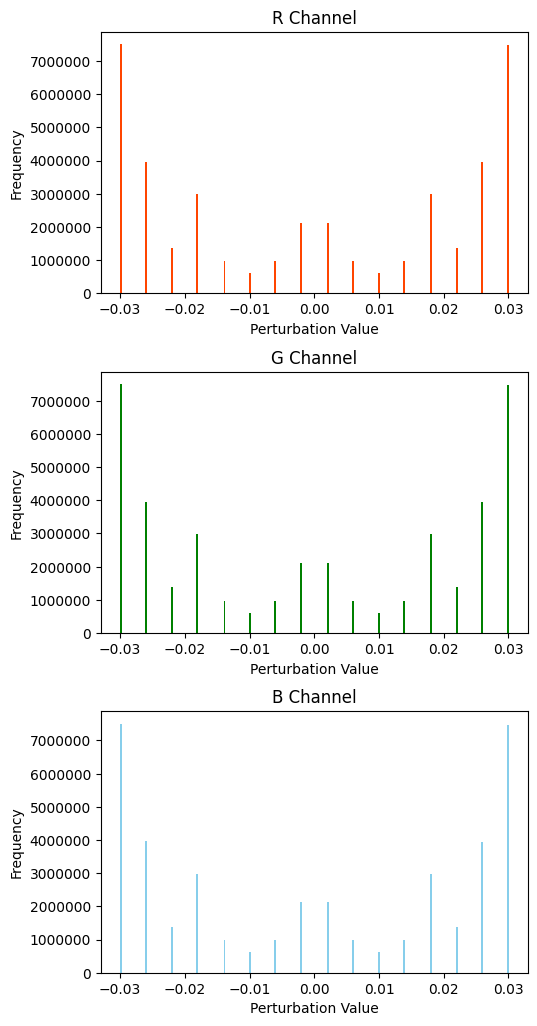

In [109]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,10))
title = "RGB"
fig.tight_layout()
colors = ['orangered','green','skyblue']
for i,c in enumerate([r_channels, g_channels, b_channels]):
  temp = r_channels.flatten()
  q25, q75 = np.percentile(temp, [25, 75])
  bin_width = 2 * (q75 - q25) * len(temp) ** (-1/3)
  bins = round((temp.max() - temp.min()) / bin_width)

  ax[i].hist(temp,density=False,bins=bins, color=colors[i])
  ax[i].set_title(f"{title[i]} Channel")
  ax[i].set_xlabel("Perturbation Value")
  ax[i].set_ylabel("Frequency")
  ax[i].ticklabel_format(useOffset=False, style='plain')
fig.subplots_adjust(hspace=0.3)
plt.show()

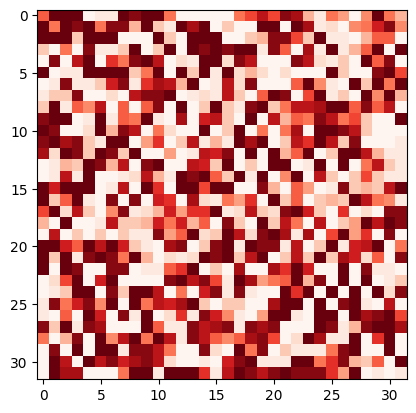

In [111]:
temp = pert_map_loaded[5][0] + 1
plt.imshow(temp / temp.max(), cmap='Reds')

In [112]:
value_weights = np.array(np.unique(r_channels.flatten(), return_counts = True))
value_weights[1] = value_weights[1] / value_weights[1].sum()

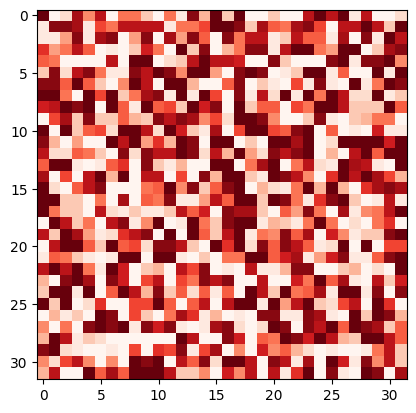

In [113]:
random_mat = np.random.choice(value_weights[0], p=value_weights[1], size=(32,32)) + 1
plt.imshow(random_mat / random_mat.max(), cmap='Reds')

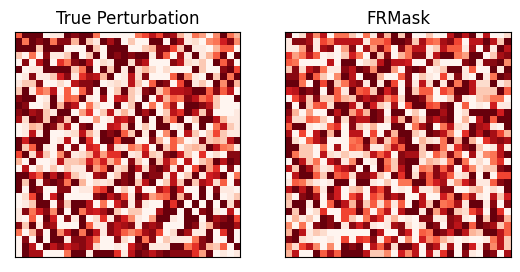

In [114]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(temp / temp.max(), cmap='Reds')
axs[0].set_title("True Perturbation")
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(random_mat / random_mat.max(), cmap='Reds')
axs[1].set_title("FRMask")
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.show()

In [45]:
random_mat

array([[0.97000036, 1.02599967, 1.02599967, ..., 1.02599967, 0.97000039,
        1.00199997],
       [0.99800003, 1.03000006, 1.00199997, ..., 1.02199972, 1.01799977,
        0.99400008],
       [1.01799977, 0.97800028, 1.01399982, ..., 0.98200023, 0.98600018,
        1.02999961],
       ...,
       [0.97000039, 0.98600018, 0.98199996, ..., 0.99800003, 0.97000039,
        0.97000039],
       [1.01799977, 0.97400033, 1.01799977, ..., 1.02999958, 1.02199972,
        1.00600001],
       [0.97399995, 1.03000008, 0.98600015, ..., 0.97000039, 1.02999961,
        1.00999987]])

In [46]:
np.all([np.sort(np.unique(r_channels.flatten(), return_counts = True)[0]),
np.sort(np.unique(g_channels.flatten(), return_counts = True)[0]),
np.sort(np.unique(b_channels.flatten(), return_counts = True)[0])])

True

As seen above, all channels have the same perturbation values overall

In [47]:
import cv2

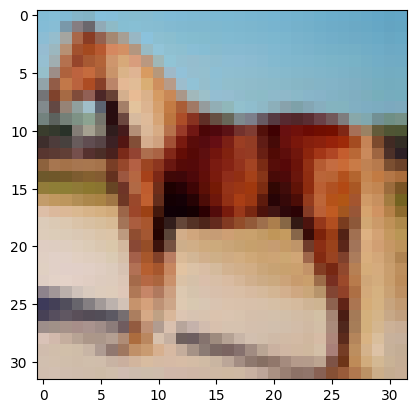

In [48]:
t = None
for x,y in trainloader:
    # for i, im in enumerate(x):
    #     # print(i)
    #     plt.imshow(im.T)
    #     plt.show()
    t = x[43].detach().cpu().numpy()
    break
t_base = cv2.rotate(t.T, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(t_base)

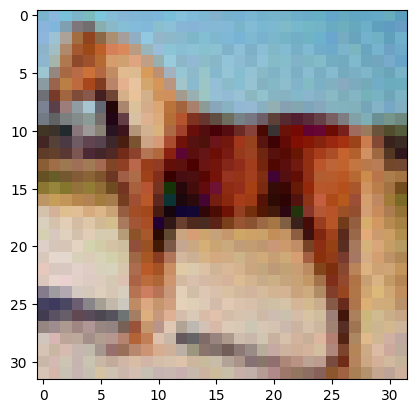

In [49]:
t_adv = pert_map_loaded[43] + t
t_adv = cv2.rotate(t_adv.T, cv2.ROTATE_90_CLOCKWISE)
t_adv[t_adv < 0] = 0.2
plt.imshow(t_adv)

In [50]:
def apply_pmap_single(img, val_weights):
    for i in range(img.shape[0]):
        random_mat = np.random.choice(val_weights[i][0], p=val_weights[i][1], size=img.shape[1:])
        img[i] += random_mat
    return img

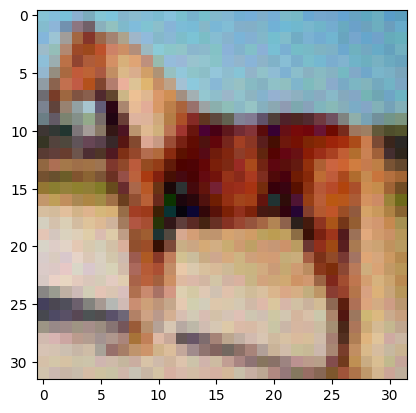

In [51]:
r = np.array(np.unique(r_channels.flatten(), return_counts = True))
r[1] = r[1] / r[1].sum()
g = np.array(np.unique(g_channels.flatten(), return_counts = True))
g[1] = g[1] / g[1].sum()
b = np.array(np.unique(b_channels.flatten(), return_counts = True))
b[1] = b[1] / b[1].sum()
val_weights = [r,g,b]
t_pert = apply_pmap_single(t, val_weights)
t_pert[t_pert < 0] = 0.2
t_pert = cv2.rotate(t_pert.T, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(t_pert)

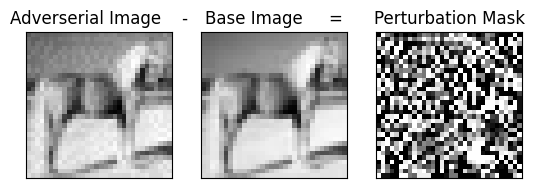

In [90]:
fig, axs = plt.subplots(1,3)

temp = cv2.rotate(t_adv.T[0], cv2.ROTATE_90_CLOCKWISE)
axs[0].imshow(temp,  cmap='gray')
axs[0].set_title("Adverserial Image    -")
axs[0].set_xticks([])
axs[0].set_yticks([])

temp = cv2.rotate(t_base.T[0], cv2.ROTATE_90_CLOCKWISE)
axs[1].imshow(temp, cmap='gray')
axs[1].set_title("Base Image     =", horizontalalignment='center')
axs[1].set_xticks([])
axs[1].set_yticks([])

temp = cv2.rotate(t_adv.T[0] - t_base.T[0], cv2.ROTATE_90_CLOCKWISE)
axs[2].imshow(temp,  cmap='gray')
axs[2].set_title("Perturbation Mask")
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.show()

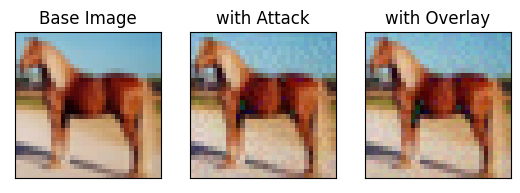

In [110]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(t_base)
axs[0].set_title("Base Image")
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(t_adv)
axs[1].set_title("with Attack")
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(t_pert)
axs[2].set_title("with Overlay")
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.show()

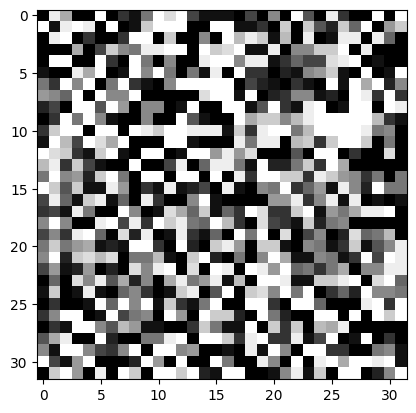

In [57]:
plt.imshow(t_adv.T[0]-t_base.T[0], cmap='gray')

### Adversarial Training

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

subset = torch.utils.data.Subset(trainset, indices=np.arange(40000))
del subset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=2)

Files already downloaded and verified


In [4]:
def apply_pmap(batch, val_weights):
    out = []
    for img in batch.numpy():
        for i in range(img.shape[0]):
            random_mat = np.random.choice(val_weights[i][0], p=val_weights[i][1], size=img.shape[1:])
            img[i] += random_mat
        out.append(img)
            
    return torch.tensor(np.array(out))

In [5]:
def load_pert_maps():
    pgd_maps = {}
    for i in [2,3,4,5,6,7]:
        pert_map_loaded = joblib.load(f"perturbation_mapsPGD_40k_steps{i}.dump")
        
        r_channels = np.concatenate(pert_map_loaded[:,0,:])
        g_channels = np.concatenate(pert_map_loaded[:,1,:])
        b_channels = np.concatenate(pert_map_loaded[:,2,:])
        
        r = np.array(np.unique(r_channels.flatten(), return_counts = True))
        r[1] = r[1] / r[1].sum()
        g = np.array(np.unique(g_channels.flatten(), return_counts = True))
        g[1] = g[1] / g[1].sum()
        b = np.array(np.unique(b_channels.flatten(), return_counts = True))
        b[1] = b[1] / b[1].sum()
        pgd_maps[i] = [r,g,b]
    return pgd_maps


val_weights = load_pert_maps()        

In [6]:
def adv_train(model, loader, num_epoch = 10): # Train the model
    print("Start training...")
    model.train() # Set the model to training mode
    for i in range(num_epoch):
        
        adjust_learning_rate(optimizer, i, lr)
        
        running_loss = []
        correct=0
        for batch, label in tqdm(loader):
            label = label.to(device)
            
            # train on abse sample
            batch = batch.to(device)
            optimizer.zero_grad() # Clear gradients from the previous iteration
            pred = model(batch) # This will call Network.forward() that you implement
            loss = criterion(pred, label) # Calculate the loss
            running_loss.append(loss.item())
            loss.backward() # Backprop gradients to all tensors in the network
            optimizer.step() # Update trainable weights
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
            
            # training on pgd steps adv data
            for key in val_weights:
                p_batch = apply_pmap(batch.detach().cpu(), val_weights[key])
                p_batch = p_batch.to(device)
                
                optimizer.zero_grad() # Clear gradients from the previous iteration
                pred = model(p_batch) # This will call Network.forward() that you implement
                loss = criterion(pred, label) # Calculate the loss
                running_loss.append(loss.item())
                loss.backward() # Backprop gradients to all tensors in the network
                optimizer.step() # Update trainable weights
                correct += (torch.argmax(pred,dim=1)==label).sum().item()
                    
        acc = correct/(len(loader.dataset)*(len(val_weights.keys())+1))
        
        print(f"Epoch {i}\t\tacc: {acc:.4f}")
        print("\t\tloss: {}".format(np.mean(running_loss))) # Print the average loss for this epoch
    print("Done!")

In [7]:
def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    lr = lr * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
model = torch.load("vgg_cifar.h5")  

In [9]:
import torch.optim as optim
lr = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9,weight_decay=5e-4)

In [ ]:
adv_train(model, trainloader)

In [11]:
torch.save(model, "vgg_cifar_adv_train.h5")

### FINAL STEP - Test attacks on the models

In [ ]:
model_2 = torch.load("vgg_cifar.h5")
og_acc = evaluate(model_2, testloader)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:08<00:00, 34.82it/s]

Evaluation accuracy: 0.8842


In [ ]:
model_1 = torch.load("vgg_ciar_adv_train.h5")
adv_acc = evaluate(model_1, testloader)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:09<00:00, 34.05it/s]

Evaluation accuracy: 0.9095


In [ ]:
# del model

In [ ]:
def evaluate_attack(model, loader, attack, attack_name, steps=None): # Evaluate accuracy on validation / test set
    model.eval() # Set the model to evaluation mode
    correct = 0
    with torch.no_grad(): # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            with torch.enable_grad():
                if attack_name == "FGSM":
                    batch = attack.attack(batch, label)
                elif attack_name == "PGD":
                    batch = attack.attack(batch, label, steps)
            pred = model(batch)
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    return acc

In [ ]:
class PerturbPGD():
    def __init__(self, model, epsilon=0.007, alpha=0.001):
        self.epsilon = epsilon
        self.model = model
        self.steps = 2
        self.alpha = alpha
        self.device = device
    
    def attack(self, X, y, steps=None):
        if steps != None:
            self.steps = steps
        
        # Creating copy of input that gets iteratively perturbated
        # using torch.autograd.Variable through the process since without it gradients arent being stored
        X_updt = torch.autograd.Variable(X.data, requires_grad=True)
        for i in range(self.steps):
            pred = self.model(X_updt)
            # zeroing gradients
            self.model.zero_grad()
            loss = F.cross_entropy(pred, y)
            loss.backward()
            # extract signs of gradients and permute alphas
            alphas = alpha * torch.sign(X_updt.grad)
            # update input features with alpha
            X_updt = torch.autograd.Variable(X_updt + alphas, requires_grad=True)
            # perturbate 
            X_updt = torch.autograd.Variable(X_updt + torch.clamp(X_updt - X, min=-self.epsilon, max=self.epsilon), requires_grad=True)
        return X_updt



In [ ]:
epsilon = 25./255.
alpha = 0.001
succ_rate = []
for i in range(1,8):
    pgd_acc = evaluate_attack(model_2, testloader, PerturbPGD(model_2, epsilon, alpha), "PGD", steps=i)
    succ = (og_acc-pgd_acc)/og_acc
    succ_rate.append(succ)
    print(f"PGD Perpturbation applied on test set - Steps: {i}\taccuracy: {pgd_acc:.4f}\tattack success rate: {succ*100:.2f}%")

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:17<00:00, 17.98it/s]


PGD Perpturbation applied on test set - Steps: 1	accuracy: 0.7053	attack success rate: 20.23%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.84it/s]


PGD Perpturbation applied on test set - Steps: 2	accuracy: 0.3624	attack success rate: 59.01%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:35<00:00,  8.80it/s]


PGD Perpturbation applied on test set - Steps: 3	accuracy: 0.1048	attack success rate: 88.15%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:44<00:00,  6.98it/s]


PGD Perpturbation applied on test set - Steps: 4	accuracy: 0.0270	attack success rate: 96.95%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:54<00:00,  5.76it/s]


PGD Perpturbation applied on test set - Steps: 5	accuracy: 0.0107	attack success rate: 98.79%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:03<00:00,  4.96it/s]


PGD Perpturbation applied on test set - Steps: 6	accuracy: 0.0138	attack success rate: 98.44%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:12<00:00,  4.31it/s]

PGD Perpturbation applied on test set - Steps: 7	accuracy: 0.0442	attack success rate: 95.00%


In [ ]:
pgd_attack_1_metrics = np.array([[1, 0.7053, 0.2023],[2,0.3624,0.5901],[3,0.1048,00.8815],[4,0.0270, 0.9695], [5, 0.0107, 0.9879], [6, 0.0318, 0.9844], [7, 0.0443, 0.9500]])

In [ ]:
# del model_2

In [ ]:
epsilon = 25./255.
alpha = 0.001
succ_rate = []
for i in range(1,8):
    pgd_acc = evaluate_attack(model_1, testloader, PerturbPGD(model_1, epsilon, alpha), "PGD", steps=i)
    succ = (adv_acc-pgd_acc)/adv_acc
    succ_rate.append(succ)
    print(f"PGD Perpturbation applied on test set - Steps: {i}\taccuracy: {pgd_acc:.4f}\tattack success rate: {succ*100:.2f}%")

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:18<00:00, 17.13it/s]


PGD Perpturbation applied on test set - Steps: 1	accuracy: 0.7996	attack success rate: 12.08%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.76it/s]


PGD Perpturbation applied on test set - Steps: 2	accuracy: 0.5335	attack success rate: 41.34%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:35<00:00,  8.79it/s]


PGD Perpturbation applied on test set - Steps: 3	accuracy: 0.2415	attack success rate: 73.45%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:45<00:00,  6.82it/s]


PGD Perpturbation applied on test set - Steps: 4	accuracy: 0.0883	attack success rate: 90.29%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:56<00:00,  5.56it/s]


PGD Perpturbation applied on test set - Steps: 5	accuracy: 0.0431	attack success rate: 95.26%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:06<00:00,  4.70it/s]


PGD Perpturbation applied on test set - Steps: 6	accuracy: 0.0357	attack success rate: 96.07%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:15<00:00,  4.16it/s]

PGD Perpturbation applied on test set - Steps: 7	accuracy: 0.0669	attack success rate: 92.64%


In [ ]:
pgd_attack_2_metrics = np.array([[1,0.7996, 0.1208],[2,0.5335, 000.4134],[3,0.2415, 0.7345],[4,0.0883, 00.9029], [5, 0.0431, 0.9526], [6, 0.0357, 0.9607], [7, 0.0669, 0.9264]])

In [ ]:
# test samples attacked using og model on adv trained model
epsilon = 25./255.
alpha = 0.001
succ_rate = []
for i in range(1,8):
    pgd_acc = evaluate_attack(model_1, testloader, PerturbPGD(model_2, epsilon, alpha), "PGD", steps=i)
    succ = (adv_acc-pgd_acc)/adv_acc
    succ_rate.append(succ)
    print(f"PGD Perpturbation applied on test set - Steps: {i}\taccuracy: {pgd_acc:.4f}\tattack success rate: {succ*100:.2f}%")

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:18<00:00, 17.38it/s]


PGD Perpturbation applied on test set - Steps: 1	accuracy: 0.8641	attack success rate: 4.99%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.33it/s]


PGD Perpturbation applied on test set - Steps: 2	accuracy: 0.7317	attack success rate: 19.55%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:37<00:00,  8.41it/s]


PGD Perpturbation applied on test set - Steps: 3	accuracy: 0.4231	attack success rate: 53.48%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:46<00:00,  6.68it/s]


PGD Perpturbation applied on test set - Steps: 4	accuracy: 0.1232	attack success rate: 86.45%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:56<00:00,  5.54it/s]


PGD Perpturbation applied on test set - Steps: 5	accuracy: 0.0365	attack success rate: 95.99%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:05<00:00,  4.81it/s]


PGD Perpturbation applied on test set - Steps: 6	accuracy: 0.0359	attack success rate: 96.05%


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:11<00:00,  4.36it/s]

PGD Perpturbation applied on test set - Steps: 7	accuracy: 0.0742	attack success rate: 91.84%


In [ ]:
pgd_attack_3_metrics = np.array([[1,0.8641, 0.0499],[2,0.7317, 0.1955],[3,0.4231, 0.5348],[4,0.1232, 0.8645], [5, 0.0365, 0.9599], [6, 0.0359, 0.9605], [7, 0.0742, 0.9184]])

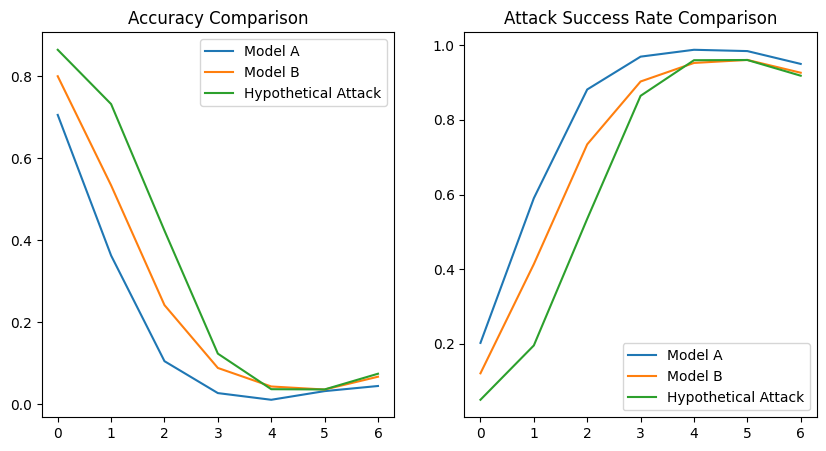

In [ ]:
# plot training metrics
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(pgd_attack_1_metrics.T[1], label="Model A")
ax[0].plot(pgd_attack_2_metrics.T[1], label="Model B")
ax[0].plot(pgd_attack_3_metrics.T[1], label="Hypothetical Attack")
ax[0].legend()
ax[0].set_title("Accuracy Comparison")

ax[1].plot(pgd_attack_1_metrics.T[2], label="Model A")
ax[1].plot(pgd_attack_2_metrics.T[2], label="Model B")
ax[1].plot(pgd_attack_3_metrics.T[2], label="Hypothetical Attack")
ax[1].legend()
ax[1].set_title("Attack Success Rate Comparison")

# fig.subplots_adjust(wspace=1.2)
plt.show()